In [1]:
# import required libraries
import torch
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import cv2 as cv
import time
import numpy as np 
import torchvision.models as models
from PIL import Image
import torch.nn as nn
import json
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from IPython.display import display
import torch.optim as optim
import torch.nn.functional as F


In [2]:
def setDevice():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using {device}")
    return device

In [3]:
def loadYoloModel():
    model = torch.hub.load("ultralytics/yolov5", "yolov5x6", pretrained=True)
    return model

In [4]:
def detectSingleImage(imagePath, device, model, isPath, image):
    if isPath:
        image = Image.open(imagePath).convert('RGB')
    else:
        image = image
    start = time.time()

    
    with torch.no_grad():
        result = model(image)
        result.print()
        #print(result.xyxy)
        #print("Names")
        #print(result.pandas().xyxy[0]["name"])
        resultNames = result.pandas().xyxy[0]["name"]
        predictions = result.xyxy[0]

        for i in range(len(predictions)):
            prediction = predictions[i].tolist()
            # print(prediction)
            #print(f"prediction {i}, {resultNames[i]}")
            #print(prediction)
            
            
            if resultNames[i] == "person":
                indexOfClosest = None
                distance = image.size[0]
                for j in range(len(predictions)):
                    prediction2 = predictions[j].tolist()

                    if resultNames[j] == "person":
                        continue
                    else:
                        #print("prediction for non human object")
                        #print(prediction2)

                        # pil image pixel value changing
                        temp = np.array(image)

                        # debug (draw one pixel green)
                        #print("coordinates")
                        #print(round(prediction2[0]))
                        #print(round(prediction2[1]))
                        temp[round(prediction2[1])][round(prediction2[0])]   = [0, 255, 0]
                        image = Image.fromarray(temp)
                        # debug

                        personCenters = (
                            (prediction[2] + prediction[0]) // 2, # (xmax + xmin) / 2  -> x but column value
                            (prediction[3] + prediction[1]) // 2  # (ymax + ymin) / 2  -> y but row value
                        )

                        objCenters = (
                            (prediction2[2] + prediction2[0]) // 2, # (xmax + xmin) / 2  -> x but column value
                            (prediction2[3] + prediction2[1]) // 2  # (ymax + ymin) / 2  -> y but row value
                        )
                        ImageDraw.Draw(image).line((personCenters[0],personCenters[1], objCenters[0], objCenters[1] ), fill="red", width=3)

                        radius = 4
                        ImageDraw.Draw(image).ellipse((personCenters[0]-radius,personCenters[1]-radius,personCenters[0]+radius, personCenters[1]+radius), fill="red", outline="red")
                        ImageDraw.Draw(image).ellipse((objCenters[0]-radius,objCenters[1]-radius,objCenters[0]+radius, objCenters[1]+radius), fill="red", outline="red")


            x_min = round(prediction[0])
            y_min = round(prediction[1])
            x_max = round(prediction[2])
            y_max = round(prediction[3])
            cfdnc = prediction[4]
            if cfdnc < 0.4 and resultNames[i] != "person":
                continue
            color = None
            if resultNames[i] == "person":
                color = "blue"
            else:
                color = "green"  
            ImageDraw.Draw(image).rectangle([x_min,y_min,x_max,y_max], outline =color, width=3)
    
    print(f"Took {time.time()-start} seconds.")
    return image

In [5]:
# set device
device = setDevice()

Using cpu


In [6]:
# loading pretrained model
yoloModel = loadYoloModel()
yoloModel

Using cache found in C:\Users\Burak/.cache\torch\hub\ultralytics_yolov5_master


requirements: seaborn>=0.11.0 not found and is required by YOLOv5, attempting auto-update...
requirements: Command 'pip install 'seaborn>=0.11.0'' returned non-zero exit status 1.
requirements: 1 package updated per C:\Users\Burak\.cache\torch\hub\ultralytics_yolov5_master\requirements.txt
requirements:  Restart runtime or rerun command for updates to take effect



Fusing layers... 
Model Summary: 606 layers, 141755500 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  2021-6-7 torch 1.8.1+cpu CPU



AutoShape(
  (model): Model(
    (model): Sequential(
      (0): Focus(
        (conv): Conv(
          (conv): Conv2d(12, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
      (1): Conv(
        (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )

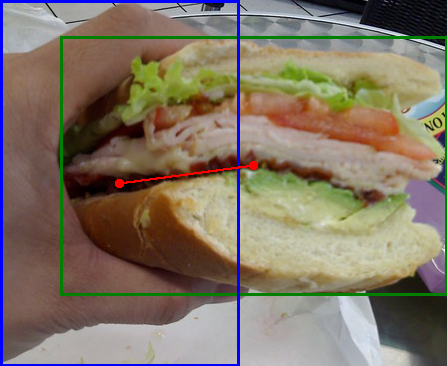

In [7]:
def selectHighestScoreImage(imagePath, device, model, isPath, image):
    if isPath:
        image = Image.open(imagePath).convert('RGB')
    else:
        image = image
    start = time.time()
        

    with torch.no_grad():
        result = model(image)
        # result.print()
        resultNames = result.pandas().xyxy[0]["name"]
        # max values
        personMax = 0
        personIndex = None
        objectMax = 0
        objectIndex = None
        for i, prediction in enumerate(result.xyxy[0],0):
            if resultNames[i] == "person":
                if prediction[4] > personMax:
                    personMax = prediction[4]
                    personIndex = i
                else:
                    pass
            else:
                if prediction[4] > objectMax:
                    objectMax = prediction[4]
                    objectIndex = i
            
        if objectIndex is None:
            if personIndex is not None:
                objectIndex = personIndex
        elif personIndex is None:
            if objectIndex is not None:
                personIndex = objectIndex
        elif (personIndex is None) and (objectIndex is None):
            return [image, image, image]
        
        # print(f"{resultNames[i]}, {prediction}, {prediction[4]}")
        # print(personIndex, personIndex is not None,  personIndex is None)
        # print(objectIndex, objectIndex is not None,  objectIndex is None)
        # print(f"object: {objectMax}, {resultNames[objectIndex]},{result.xyxy[0][objectIndex]}")
        # print(f"person: {personMax}, {resultNames[personIndex]},{result.xyxy[0][personIndex]}")
        
        
        objCoordinates = result.xyxy[0][objectIndex][:4]
        personCoordinates = result.xyxy[0][personIndex][:4]
        objCoordinates = objCoordinates.cpu().detach().numpy().astype(int)
        personCoordinates = personCoordinates.cpu().detach().numpy().astype(int)

        humanImage = image.crop(list(personCoordinates))
        objectImage = image.crop(list(objCoordinates))



        # drawing rectangles and linking lines for pair stream
        ImageDraw.Draw(image).rectangle(list(objCoordinates),width=3, outline="green")
        ImageDraw.Draw(image).rectangle(list(personCoordinates),width=3, outline="blue")

        #linking
        objCenters = (
            (objCoordinates[2] + objCoordinates[0]) // 2, # (xmax + xmin) / 2  -> x but column value
            (objCoordinates[3] + objCoordinates[1]) // 2  # (ymax + ymin) / 2  -> y but row value
        )

        personCenters = (
            (personCoordinates[2] + personCoordinates[0]) // 2, # (xmax + xmin) / 2  -> x but column value
            (personCoordinates[3] + personCoordinates[1]) // 2  # (ymax + ymin) / 2  -> y but row value
        )
        ImageDraw.Draw(image).line((personCenters[0],personCenters[1], objCenters[0], objCenters[1] ), fill="red", width=3)
        radius = 4
        ImageDraw.Draw(image).ellipse((personCenters[0]-radius,personCenters[1]-radius,personCenters[0]+radius, personCenters[1]+radius), fill="red", outline="red")
        ImageDraw.Draw(image).ellipse((objCenters[0]-radius,objCenters[1]-radius,objCenters[0]+radius, objCenters[1]+radius), fill="red", outline="red")


        pairWise_x_min = min([objCoordinates[0], personCoordinates[0]])
        pairWise_y_min = min([objCoordinates[1], personCoordinates[1]])
        pairWise_x_max = max([objCoordinates[2], personCoordinates[2]])
        pairWise_y_max = max([objCoordinates[3], personCoordinates[3]])
        pairWiseStream = image.crop([pairWise_x_min,pairWise_y_min ,pairWise_x_max ,pairWise_y_max ])

        
        return [humanImage, objectImage, pairWiseStream]
        
        
tempImage = selectHighestScoreImage("./dataset/train2015/train/HICO_train2015_00000265.jpg", device, yoloModel, True, None)
tempImage[2]

image 1/1: 427x640 17 persons, 1 horse
Speed: 4.0ms pre-process, 1190.8ms inference, 2.0ms NMS per image at shape (1, 3, 448, 640)
Took 1.2317078113555908 seconds.


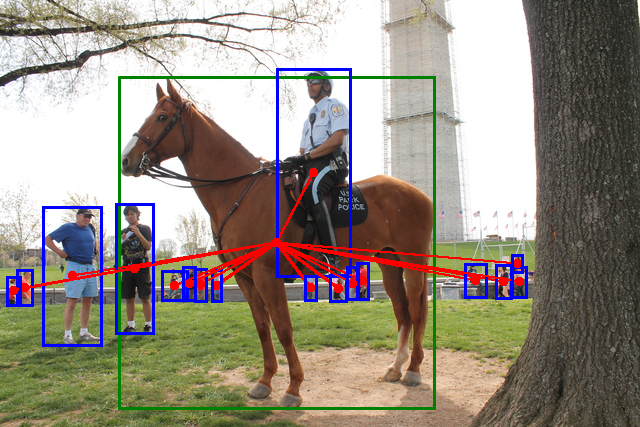

In [8]:
resultImage = detectSingleImage("./dataset/train2015/train/HICO_train2015_00000010.jpg", device, yoloModel, True, None)
resultImage

In [9]:
def readAnnotationFiles():
    trainJSONFile = open('./annotations/train_data_with_obj_id.json')
    testJSONFile = open("./annotations/test_data_with_obj_id.json")
    verbJSONFile = open('./annotations/verb_dict.json')
    verbFile = open('./annotations/hico_list_vb.txt',"r")
    hoiFile = open('./annotations/hico_list_hoi.txt', "r")   
    objFile = open('./annotations/hico_list_obj.txt', "r")
    

    # reading and configuring txt files
    verbFileArray = verbFile.read().split("\n")
    hoiFileArray = hoiFile.read().split("\n")
    objFileArray = objFile.read().split("\n")
    
    for i in range(len(objFileArray)):
        objFileArray[i] = objFileArray[i].strip(" ").split(" ")[-1]
    
    # loading json files
    trainAnnotationDictionary = json.load(trainJSONFile)
    verbDictionary = json.load(verbJSONFile)
    testAnnotationDictionary = json.load(testJSONFile)

    # closing files which has opened
    trainJSONFile.close()
    verbJSONFile.close()
    verbFile.close()
    hoiFile.close()
    objFile.close()
    testJSONFile.close()
    
    return trainAnnotationDictionary, testAnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray, objFileArray


def targetVectorOfAllImages(AnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray):
    imageNames = AnnotationDictionary["name"]
    actionNumbers = AnnotationDictionary["action_no"]
    objectList = AnnotationDictionary["obj_list"]
    objectIDs = AnnotationDictionary["obj_id"]
    
    verbArray = list(verbDictionary.values())

    targetVectors = []
    for i in imageNames:
        actionIndexes = actionNumbers[i]
        targetVector = np.zeros(117)

        for j in actionIndexes:
            # getting relevant verb
            tempVerb = hoiFileArray[j - 1].strip(" ").split(" ")[-1]

            # getting index of verb
            tempIndex = verbArray.index(tempVerb)

            # setting correct values
            targetVector[tempIndex] = 1

            print([imageNames[i]], objectList[i], [tempVerb])
        
        targetVectors.append(targetVector)
        
    return targetVectors
 
def getIndividualTargetVector(imageName, AnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray, objFileArray):
    imageNames = AnnotationDictionary["name"]
    actionNumbers = AnnotationDictionary["action_no"]
    objectList = AnnotationDictionary["obj_list"]
    objectIDs = AnnotationDictionary["obj_id"]

    verbArray = list(verbDictionary.values())
    imageNameArray = list(imageNames.values())

    # extract image index
    imageIndex = imageNameArray.index(imageName)

    # only image names
    imageNamesList = list(imageNames.values())

    #initial target vector
    targetVector = np.zeros(600)

    # extract action indexes 
    actionIndexes = list(actionNumbers.values())[imageIndex]

    # convert object list 
    objectList = list(objectList.values())
    for i in actionIndexes:
        targetVector[i-1] = 1
        
    return targetVector
    
    
def getIndividualTargetVector_old(imageName, AnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray, objFileArray):
    imageNames = AnnotationDictionary["name"]
    actionNumbers = AnnotationDictionary["action_no"]
    objectList = AnnotationDictionary["obj_list"]
    objectIDs = AnnotationDictionary["obj_id"]
    
    verbArray = list(verbDictionary.values())
    imageNameArray = list(imageNames.values())
    
    
    # extract image index
    imageIndex = imageNameArray.index(imageName)
    
    
    # only image names
    imageNamesList = list(imageNames.values())
    
    #initial target vector
    targetVector = np.zeros(117)
    
    # extract action indexes 
    actionIndexes = list(actionNumbers.values())[imageIndex]
    
    
    # convert object list 
    objectList = list(objectList.values())
    for i in actionIndexes:
        verb = hoiFileArray[i - 1].strip(" ").split(" ")[-1]
        
        tempIndex = verbArray.index(verb)
        
        targetVector[tempIndex] = 1
        
        #obj = objectList[imageIndex - 1].split(" ")[-1]
        objIndex = objFileArray.index(objectList[imageIndex - 1][0])
        
        #print([imageNamesList[imageIndex - 1]], objectList[imageIndex - 1], [verb])
        #print(imageIndex - 1)
        #print(objIndex)
    
    return [objIndex, targetVector]   



In [10]:
"""read needed files and configure"""
trainAnnotationDictionary, testAnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray, objFileArray = readAnnotationFiles()

"""create target vector for all the images"""
# targetVectorOfAllImages(trainAnnotationDictionary, verbDictionary, verbFileArray, hoiFileArray

"""return target vector of given image"""

targetVector = getIndividualTargetVector("HICO_train2015_00000020.jpg",trainAnnotationDictionary,verbDictionary, verbFileArray, hoiFileArray, objFileArray)

print(targetVector)  

[          0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0 

In [11]:
class CustomTransform(object):
    def __call__(self,image):
        drawedImage = selectHighestScoreImage(None, device, yoloModel, False, image)
            # function call
        return drawedImage

In [12]:

def loadDataset(dataset_path, hoiFileArray):

    # transform = transforms.Compose([
    #     CustomTransform() # 
    # ])

    # , transform=transform
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)

    
    

    #target vector replacement
    for i in range(len(dataset.imgs)):

        tempImageName = dataset.imgs[i][0].split("\\")[-1]
        targetVector = getIndividualTargetVector(tempImageName,trainAnnotationDictionary,verbDictionary, verbFileArray, hoiFileArray, objFileArray)
        # print(len(targetVector))
        dataset.imgs[i] = (dataset.imgs[i][0], targetVector)
        if (i % 1000 == 0):
            print(i)
            
    # changing classes
    try:
        for i,value in enumerate(hoiFileArray,0):
            tempArray = value.strip(" ").split(" ")[2:]
            text = tempArray[0]+" "+tempArray[-1]
            hoiFileArray[i] = text
    except IndexError:
        pass

    # update dataset classes
    dataset.classes = hoiFileArray
    
    return dataset


dataset = loadDataset('./dataset/train2015', hoiFileArray)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000


In [13]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.linear1 = nn.Linear(512, 1024)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512,600)   

        # self.linear1 = nn.Linear(1536, 1024)
        # self.reu = nn.ReLU()
        # self.linear2 = nn.Linear(1024, 1024)
        # self.linear3 = nn.Linear(1024,600)

    def forward(self, x):
        residual = x
        out = self.relu(self.linear1(x))
        out = self.relu(self.linear2(out))
        out = self.linear3(out+residual)
        return out

# resnext50_32x4d 


model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Sequential()
myModel = MyModel().to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(myModel.parameters(),lr= 0.001)

In [14]:
def saveModel(model, end):
    torch.save(model, 'model_'+str(end)+'.pth')
    print("Model saved successfully")

In [15]:
def loadModel(path, device):
    return torch.load(path, map_location=device)

In [21]:

def train(epoch, savePerIteration):
    print("Learning...")


    lossValues = []
    #BCEWithLogitsLoss idi
    criterion = nn.BCELoss()
    criterion2 = nn.Sigmoid()
    optimizer = optim.Adam(myModel.parameters(),lr= 0.001)

    train_dataloader = DataLoader(dataset=dataset, batch_size = 1, shuffle = True)


    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    
    
    for i in range(epoch):
        counter = 1
        totalLoss = 0

        for j, batch in enumerate(train_dataloader, 27):
            # if j%27 != 0:
            #     continue

            minput = batch[0]
            target = batch[1]
            # print(target)
            # print(minput.shape)
            
            tempImage = transforms.ToPILImage()(minput[0]).convert('RGB')
            # print(tempImage)
            # print(target)
            
            imageArray = selectHighestScoreImage(None, device, yoloModel, False, tempImage)
            # print(imageArray)
            humanImage = imageArray[0]
            objectImage = imageArray[1]
            pairWiseStream = imageArray[2]
            
            #transforms
            tempTransforms  = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std)
            ])
            humanImage = tempTransforms(humanImage).unsqueeze(1).permute(1,0,2,3)
            objectImage = tempTransforms(objectImage).unsqueeze(1).permute(1,0,2,3)
            pairWiseStream = tempTransforms(pairWiseStream).unsqueeze(1).permute(1,0,2,3)
            # print(humanImage.shape)
            
            # resnet model
            humanOutput = model(humanImage.to(device))
            objectOutput = model(objectImage.to(device))
            pairWiseStreamOutput = model(pairWiseStream.to(device))
            #deneme
            # testInput = torch.cat((humanOutput, objectOutput, pairWiseStreamOutput), 1)
            # print(humanOutput.shape)
            #deneme
        
            # our model output
            humanOutput = myModel(humanOutput.to(device))
            objectOutput = myModel(objectOutput.to(device))
            pairWiseStreamOutput = myModel(pairWiseStreamOutput.to(device))
            
            
            elementWiseSum = (humanOutput + objectOutput + pairWiseStreamOutput)/3
            
            # print(elementWiseSum)
            
            
            # print(elementWiseSum.shape, elementWiseSum)
            # print(target.shape, target)
            # print(humanOutput.shape)
            # print(humanOutput)
            # our model
            # print(target)
            
            # print(elementWiseSum.shape)
            # print(target.shape)
            
            #deneme
            #print(testInput.shape)
            #testOutput = myModel(testInput)
            
            # loss = criterion(testInput, target.to(device))
            loss = criterion(criterion2(elementWiseSum).float(), target.float().to(device))
            # loss = criterion(elementWiseSum, target.to(device))
            
            # printing loss value
            # print("loss: ",loss)
            # print(elementWiseSum.shape)
            
            if counter % savePerIteration == 0:
                predictionArray = list(elementWiseSum[0])
                predictionArray = sorted(predictionArray,reverse=True)
                for l in range(5):
                    print(list(elementWiseSum[0]).index(predictionArray[l]))

                print("Reals")
                for m,value in enumerate(list(target[0]),0):
                    if value > 0.8:
                        print(m)
                    
            if counter % savePerIteration == 0:
                print(f"Avg loss: {totalLoss/counter}")
                torch.save(model, 'model_'+str(totalLoss/counter)+'.pth')
                #saveModel(myModel, f"avgloss_{totalLoss/counter}")
            
            #
            totalLoss += loss.item()
            lossValues.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            counter += 1
            # break
#             break

#             moutput = model(minput.to(device))
#             moutput = myModel(moutput.to(device))

#             # lossları ayarla
#             #loss2 = criterion2(moutput[0], target[1]).to(torch.float32)
#             loss2 = F.mse_loss(moutput[0].float(), target[1].float()).to(torch.float32)

#             #loss1 = criterion1(moutput[1], target[0]).to(torch.float32)
#             loss1 = F.cross_entropy(moutput[1].float(), target[0]).to(torch.float32)

#             """loss2 = criterion1(moutput[1], target[0])

#             loss1 = criterion2(moutput[0], target[1][0])"""

#             loss = loss1 + loss2

#             print("loss", loss.item(), j)

#             """ 
#             print("predict_class, real_class", list(moutput[1][0]).index(max(moutput[1][0])), target[0][0])
#             print(" ")

#             """


            

# 
        print("Epoch Finished", i)
        
        
train(100, 1000)


Learning...
56
108
40
109
20
Reals
148
152
153
154
155
Avg loss: 0.025319240271579474


TypeError: type numpy.ndarray doesn't define __round__ method